In [1]:
# 安装依赖
!pip install pandas pyarrow

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import pandas as pd
# 读取parquet数据
df_yellow = pd.read_parquet('data/TLC/yellow_tripdata_2024-01.parquet')
df_green = pd.read_parquet('data/TLC/green_tripdata_2024-01.parquet')
df_green.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2024-01-01 00:46:55   2024-01-01 00:58:25                  N   
1         2  2024-01-01 00:31:42   2024-01-01 00:52:34                  N   
2         2  2024-01-01 00:30:21   2024-01-01 00:49:23                  N   
3         1  2024-01-01 00:30:20   2024-01-01 00:42:12                  N   
4         2  2024-01-01 00:32:38   2024-01-01 00:43:37                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0           236           239              1.0           1.98   
1         1.0            65           170              5.0           6.54   
2         1.0            74           262              1.0           3.08   
3         1.0            74           116              1.0           2.40   
4         1.0            74           243              1.0           5.14   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0         12.8    1.0      0.5        3.61           0.0        NaN   
1         30.3    1.0      0.5        7.11           0.0        NaN   
2         19.8    1.0      0.5        3.00           0.0        NaN   
3         14.2    1.0      1.5        0.00           0.0        NaN   
4         22.6    1.0      0.5        6.28           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    1.0         21.66           1.0        1.0   
1                    1.0         42.66           1.0        1.0   
2                    1.0         28.05           1.0        1.0   
3                    1.0         16.70           2.0        1.0   
4                    1.0         31.38           1.0        1.0   

   congestion_surcharge  
0                  2.75  
1                  2.75  
2                  2.75  
3                  0.00  
4                  0.00

In [3]:
df_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56551 entries, 0 to 56550
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56551 non-null  int32         
 1   lpep_pickup_datetime   56551 non-null  datetime64[us]
 2   lpep_dropoff_datetime  56551 non-null  datetime64[us]
 3   store_and_fwd_flag     53136 non-null  object        
 4   RatecodeID             53136 non-null  float64       
 5   PULocationID           56551 non-null  int32         
 6   DOLocationID           56551 non-null  int32         
 7   passenger_count        53136 non-null  float64       
 8   trip_distance          56551 non-null  float64       
 9   fare_amount            56551 non-null  float64       
 10  extra                  56551 non-null  float64       
 11  mta_tax                56551 non-null  float64       
 12  tip_amount             56551 non-null  float64       
 13  t

# 数据清洗--缺失值异常值的处理

In [4]:
print('缺失情况：')
print(df_green.isnull().sum())

缺失情况：
VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        3415
RatecodeID                3415
PULocationID                 0
DOLocationID                 0
passenger_count           3415
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                56551
improvement_surcharge        0
total_amount                 0
payment_type              3415
trip_type                 3418
congestion_surcharge      3415
dtype: int64


In [5]:
# 详细缺失值统计--占位符0
(df_green['passenger_count'] == 0).sum(), (df_green['passenger_count'] == '').sum()

(512, 0)

In [6]:
# 首先是ehail_fee：表示电子召车平台费，整行为空删除这一行((或者可以填充0)
df_green = df_green.drop(columns=['ehail_fee'])

对于剩下的损失了3415/56551约等于6%的核心字段：  
store_and_fwd_flag、RatecodeID、passenger_count、payment_type、congestion_surcharge、trip_type。

我们分为两类，第一类为可以推导的：store_and_fwd_flag、RatecodeID、passenger_count  
不可推导的：payment_type、congestion_surcharge、trip_type。 

In [7]:
# store_and_fwd_flag：官方文档说明，空值≈“N”（未缓存）。
df_green['store_and_fwd_flag'] = df_green['store_and_fwd_flag'].fillna('N')

In [8]:
#RatecodeID：空值集中在 trip_distance=0 或 fare_amount=0 的异常/取消单里。
#对正常行程可用上下车坐标反查费率标准，简单做法：（赋值为1）
df_green['RatecodeID'] = df_green['RatecodeID'].fillna(1).astype(int)

In [9]:
#passenger_count：绿色出租没有 0 乘客场景；空值大多在异常单。
#用中位数 1 填充，或按行程距离/金额分箱后用箱内中位数填充。
df_green['passenger_count'] = df_green['passenger_count'].fillna(1).astype(int)

### 不可推导的使用众数或者中位数即可

In [10]:
df_green['payment_type'].mode()  # 求众数（如果只有nan则会返回空值）

0    1.0
Name: payment_type, dtype: float64

In [11]:
df_green['payment_type'] = df_green['payment_type'].fillna(
                           df_green['payment_type'].mode()[0]).astype(int)  # 使用众数填充
df_green['congestion_surcharge'] = df_green['congestion_surcharge'].fillna(0)

In [12]:
# trip_type：2 号含义「共享出租」，空值极少。
# 直接众数填充：
df_green['trip_type'] = df_green['trip_type'].fillna(
                        df_green['trip_type'].mode()[0]).astype(int)

In [13]:
df_green.isna().sum().sort_values(ascending=False)

VendorID                 0
extra                    0
trip_type                0
payment_type             0
total_amount             0
improvement_surcharge    0
tolls_amount             0
tip_amount               0
mta_tax                  0
fare_amount              0
lpep_pickup_datetime     0
trip_distance            0
passenger_count          0
DOLocationID             0
PULocationID             0
RatecodeID               0
store_and_fwd_flag       0
lpep_dropoff_datetime    0
congestion_surcharge     0
dtype: int64

## 异常值检测

时间异常

In [14]:
# 上车时间晚于下车时间/行程长度小于0或者时间大于24小时
df_green['trip_time'] = (df_green.lpep_dropoff_datetime
                         - df_green.lpep_pickup_datetime).dt.total_seconds()
mask1 = (df_green.trip_time <= 0) | (df_green.trip_time > 86400)
mask1.sum()

76

In [15]:
# 距离异常
# 距离《=0 且fare_amount》0 以及 trip_distance 》200km 超出纽约合理范围的
mask2 = (df_green.trip_distance <= 0 ) & (df_green.fare_amount > 0)
mask3 = df_green.trip_distance > 200
print(mask2.sum(), '\n', mask3.sum())

2759 
 46


In [16]:
#乘客数量不属于1-6
mask4 = ~df_green.passenger_count.between(1, 6)
mask4.sum()

515

In [17]:
# RatecodeID 不在官方 1~6 之间
# 机场码但行程距离 < 1 km 或起讫点不在机场区
mask5 = ~df_green.RatecodeID.isin([1, 2, 3, 4, 5, 6])
mask5.sum()

3

In [18]:
# 金额异常
money_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount',
              'tolls_amount', 'improvement_surcharge', 'total_amount']
mask6 = (df_green[money_cols] < 0).any(axis=1)  # 这些列的任意一行小于零为异常
mask7 = (df_green.fare_amount > 1000) | (df_green.total_amount > 2000)
mask6.sum(), mask7.sum()

(186, 1)

In [19]:
# 获取所有异常值条件mask_all
mask_all = mask1|mask2|mask3|mask4|mask5|mask6|mask7
bad = df_green[mask_all]
print('异常行占比：{:.2%}'.format(len(bad)/len(df_green)))

异常行占比：6.17%


In [20]:
df_green[mask_all].VendorID.sum()

5194

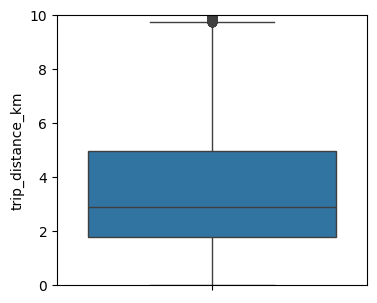

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_green['trip_distance_km'] = df_green['trip_distance'] * 1.609344
df_green['trip_distance_km'] = np.clip(df_green['trip_distance_km'], 0, 200)
plt.figure(figsize=(4,3.5))
sns.boxplot(y=df_green['trip_distance_km'])
plt.ylim(0, 10)
plt.show()

In [22]:
help(np.clip)

Help on function clip in module numpy:

clip(a, a_min, a_max, out=None, **kwargs)
    Clip (limit) the values in an array.
    
    Given an interval, values outside the interval are clipped to
    the interval edges.  For example, if an interval of ``[0, 1]``
    is specified, values smaller than 0 become 0, and values larger
    than 1 become 1.
    
    Equivalent to but faster than ``np.minimum(a_max, np.maximum(a, a_min))``.
    
    No check is performed to ensure ``a_min < a_max``.
    
    Parameters
    ----------
    a : array_like
        Array containing elements to clip.
    a_min, a_max : array_like or None
        Minimum and maximum value. If ``None``, clipping is not performed on
        the corresponding edge. Only one of `a_min` and `a_max` may be
        ``None``. Both are broadcast against `a`.
    out : ndarray, optional
        The results will be placed in this array. It may be the input
        array for in-place clipping.  `out` must be of the right shape
    

In [23]:
q = df_green['trip_distance_km'].quantile([0, .25, .5, .75, .99, 1])
print(q)

0.00      0.000000
0.25      1.770278
0.50      2.880726
0.75      4.956780
0.99     25.266701
1.00    200.000000
Name: trip_distance_km, dtype: float64


In [24]:
# 对于异常值的处理我们简单采取丢弃
df_clean = df_green[~mask_all].copy()

# 数据探索性分析（EDA）

In [25]:
# plt.rcParams['font.sans-serif'] = ['SimHei']   # 黑体
# plt.rcParams['axes.unicode_minus'] = False     # 正常显示负号

In [26]:
!pip install dask[complete] datashader fastparquet

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


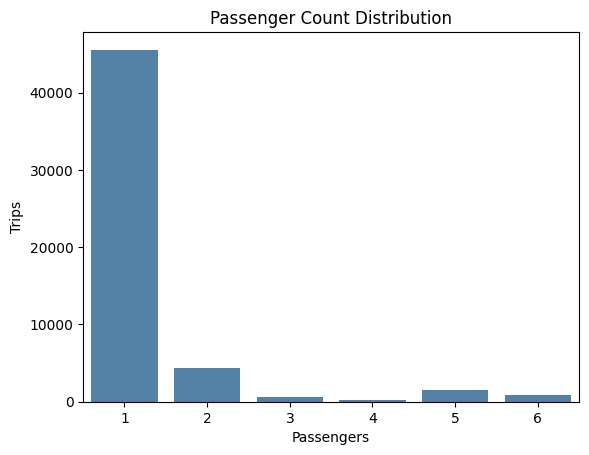

In [27]:
import dask.dataframe as dd
ddf = dd.from_pandas(df_clean, npartitions=4)    # 转化为Dask:跟据cpu核数进行区分

# 聚合
count_df = (
    ddf['passenger_count']
    .value_counts()
    .compute()         #拉回到pandas.Series
    .sort_index()
)

sns.barplot(x=count_df.index, y=count_df.values, color='steelblue')
plt.title('Passenger Count Distribution')
plt.xlabel('Passengers')
plt.ylabel('Trips')
# plt.yscale('log') # 转化为对数看的更清晰
plt.show()

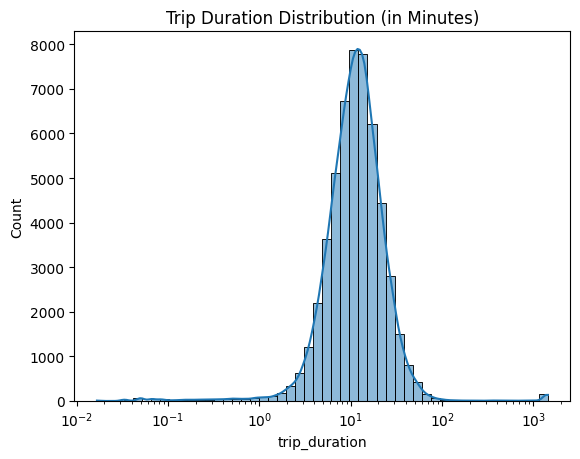

In [28]:
## 行程时间分布
df_clean['trip_duration'] = df_clean['trip_time'] / 60
sns.histplot(df_clean['trip_duration'], 
             bins=50, 
             kde=True,
            log_scale=(True, False))  #(x,y)的对数开关
plt.title('Trip Duration Distribution (in Minutes)')
plt.show()

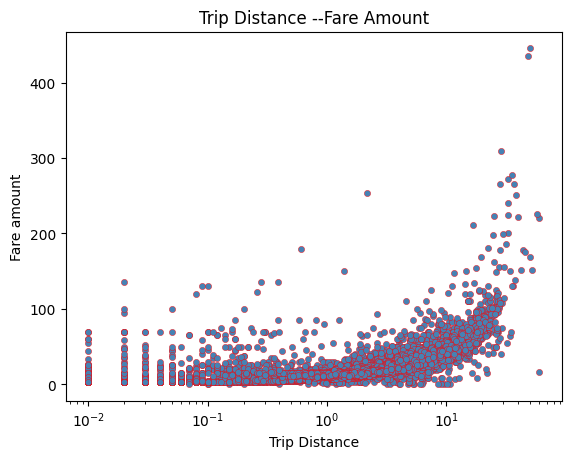

In [29]:
# 展示距离-费用的散点图
plt.scatter(df_clean['trip_distance'], df_clean['fare_amount'],
            c='steelblue',        # 填充色
            s=20,                 # 点大小，可按需调
            edgecolors='red',   # 轮廓颜色，深色背景可换成 'black' 或 'k'
            linewidths=0.3        # 轮廓线宽，0.3–1 之间比较好看
            )
plt.xlabel('Trip Distance')
plt.ylabel('Fare amount')
# plt.yscale('log')
plt.xscale('log') 
plt.title('Trip Distance --Fare Amount')
plt.show()

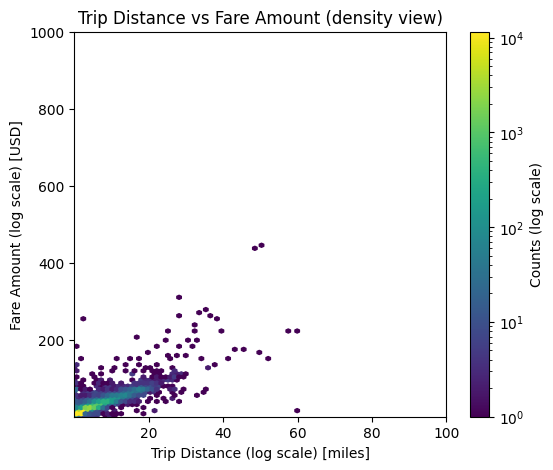

In [30]:
# 或者可以使用密度图
df_plot = df_clean
# 2) 画 hexbin（密度图）代替 scatter，可一眼看出哪里最密
fig, ax = plt.subplots(figsize=(6, 5))
hb = ax.hexbin(
    df_plot['trip_distance'],
    df_plot['fare_amount'],
    gridsize=50,              # 网格精细度
    bins='log',               # 用 log 计数上色，越亮越密
    cmap='viridis',
    mincnt=1                  # 至少 1 个点才上色
)

# 3) 把坐标轴的上下限手工拉到“有数据的区间”
ax.set_xlim(1e-2, 1e2)       # 0.01–100 英里
ax.set_ylim(1e-1, 1e3)       # 0.1–1000 美元

# 4) 加颜色条、标签
cb = fig.colorbar(hb, ax=ax, label='Counts (log scale)')
ax.set_xlabel('Trip Distance (log scale) [miles]')
ax.set_ylabel('Fare Amount (log scale) [USD]')
ax.set_title('Trip Distance vs Fare Amount (density view)')
plt.show()

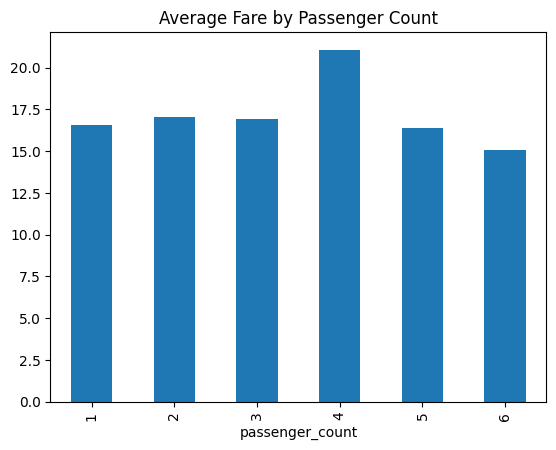

In [31]:
# 不同乘客数量下的平均费用
avg_fare_by_passengers = df_clean.groupby('passenger_count')['fare_amount'].mean()
avg_fare_by_passengers.plot(kind='bar')
plt.title('Average Fare by Passenger Count')
plt.show()

In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53062 entries, 0 to 56550
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               53062 non-null  int32         
 1   lpep_pickup_datetime   53062 non-null  datetime64[us]
 2   lpep_dropoff_datetime  53062 non-null  datetime64[us]
 3   store_and_fwd_flag     53062 non-null  object        
 4   RatecodeID             53062 non-null  int32         
 5   PULocationID           53062 non-null  int32         
 6   DOLocationID           53062 non-null  int32         
 7   passenger_count        53062 non-null  int32         
 8   trip_distance          53062 non-null  float64       
 9   fare_amount            53062 non-null  float64       
 10  extra                  53062 non-null  float64       
 11  mta_tax                53062 non-null  float64       
 12  tip_amount             53062 non-null  float64       
 13  tolls_

In [33]:
!pip install geopandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [34]:
import geopandas as gpd

# 绘制热力图
zones = gpd.read_file('data/TLC/taxi_zones.shp')
zones.head(4)

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   

     borough                                           geometry  
0        EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1     Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2      Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3  Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...

In [35]:
# 使用聚合数据
pickup_counts = df_clean.groupby('PULocationID').size().reset_index(name='pickup_count')
dropoff_counts = df_clean.groupby('DOLocationID').size().reset_index(name='dropoff_count')

In [36]:
## 合并地理信息
pickup_map = zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID')

In [37]:
!pip install folium
import folium

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [38]:
#!pip list

In [39]:

m = folium.Map(location=[40.7589, -73.9851], zoom_start=11)
folium.Choropleth(
    geo_data=pickup_map,
    name="Pickup Heatmap",
    data=pickup_map,
    columns=["LocationID", "pickup_count"],
    key_on="feature.properties.LocationID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Pickup Count"
).add_to(m)
m.save("pickup_heatmap.html")

In [40]:
display(m)

### 我们可以和原始数据进行对比

In [41]:
# 纽约绿色出租车热力图
pickup_counts = df_green.groupby('PULocationID').size().reset_index(name='pickup_count')
dropoff_counts = df_green.groupby('DOLocationID').size().reset_index(name='dropoff_count')
pickup_map = zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID')

m = folium.Map(location=[40.7589, -73.9851], zoom_start=11)
folium.Choropleth(
    geo_data=pickup_map,
    name="Pickup Heatmap",
    data=pickup_map,
    columns=["LocationID", "pickup_count"],
    key_on="feature.properties.LocationID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Pickup Count"
).add_to(m)
m

In [51]:
# # 纽约黄色出租车热力图
# pickup_counts = df_yellow.groupby('PULocationID').size().reset_index(name='pickup_count')
# dropoff_counts = df_yellow.groupby('DOLocationID').size().reset_index(name='dropoff_count')
# pickup_map = zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID')

# m = folium.Map(location=[40.7589, -73.9851], zoom_start=11)
# folium.Choropleth(
#     geo_data=pickup_map,
#     name="Pickup Heatmap",
#     data=pickup_map,
#     columns=["LocationID", "pickup_count"],
#     key_on="feature.properties.LocationID",
#     fill_color="YlOrRd",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name="Pickup Count"
# ).add_to(m)
# m

### 聚类分析

In [43]:
zones.geometry.head()

0    POLYGON ((933100.918 192536.086, 933091.011 19...
1    MULTIPOLYGON (((1033269.244 172126.008, 103343...
2    POLYGON ((1026308.77 256767.698, 1026495.593 2...
3    POLYGON ((992073.467 203714.076, 992068.667 20...
4    POLYGON ((935843.31 144283.336, 936046.565 144...
Name: geometry, dtype: geometry

In [44]:
zones['centroid'] = zones.geometry.centroid
zones['lon'] = zones.centroid.x
zones['lat'] = zones.centroid.y

# 创建map: LocationID-->(lon, lat)

print(zones['LocationID'].duplicated().sum())  # 看看有多少重复
# 先删除重复的LocationID
zones_unique = zones.drop_duplicates(subset=['LocationID'])
loc2coords = zones_unique.set_index('LocationID')[['lon', 'lat']].to_dict('index')

3


In [45]:
# help(zones.drop_duplicates)

In [46]:
# 获取有效的LocationID
valid_ids = set(zones['LocationID'])

#过滤原始数据集
df_clean = df_clean[
    df_clean['PULocationID'].isin(valid_ids) &
    df_clean['DOLocationID'].isin(valid_ids)
]

# 构建OD矩阵
od_matrix = df_clean[['PULocationID', 'DOLocationID']].value_counts().reset_index(name='count')

# 计算中点坐标（也可以使用头和尾坐标）
od_matrix['mid_lon'] = 0.5 * (
    od_matrix['PULocationID'].map(lambda x: loc2coords[x]['lon']) + 
    od_matrix['DOLocationID'].map(lambda x: loc2coords[x]['lon'])
)
od_matrix['mid_lat'] = 0.5 * (
    od_matrix['PULocationID'].map(lambda x: loc2coords[x]['lat']) + 
    od_matrix['DOLocationID'].map(lambda x: loc2coords[x]['lat'])
)


In [47]:
from sklearn.cluster import DBSCAN

In [62]:
# 最后部分--聚类
coords = np.radians(od_matrix[['mid_lat', 'mid_lon']].values)
kms_per_radian = 6371.0088
db = DBSCAN(eps=0.25/kms_per_radian, min_samples=50, metric='haversine').fit(coords)
od_matrix['cluster'] = db.labels_

# 4. 输出结果
print(od_matrix['cluster'].value_counts())

cluster
-1    4408
Name: count, dtype: int64


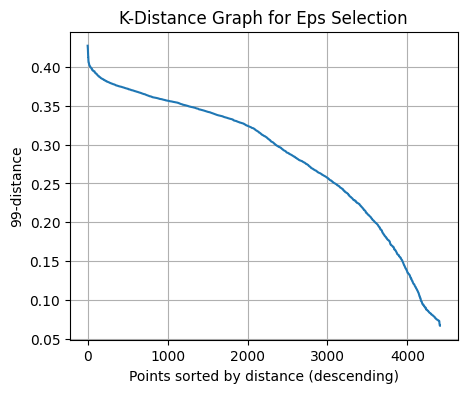

In [68]:
from sklearn.neighbors import NearestNeighbors

# 计算每个点到第k近邻的距离
k = 100 - 1  # 通常取 min_samples-1
nn = NearestNeighbors(n_neighbors=k, metric='haversine')
nn.fit(coords)
distances, _ = nn.kneighbors()
k_distances = distances[:, -1]  # 提取每个点的第k距离

sorted_k_dist = np.sort(k_distances)[::-1]  # 从大到小排序
plt.figure(figsize=(5,4))
plt.plot(sorted_k_dist)
plt.xlabel('Points sorted by distance (descending)')
plt.ylabel(f'{k}-distance')
plt.title('K-Distance Graph for Eps Selection')
plt.grid(True)
plt.show()

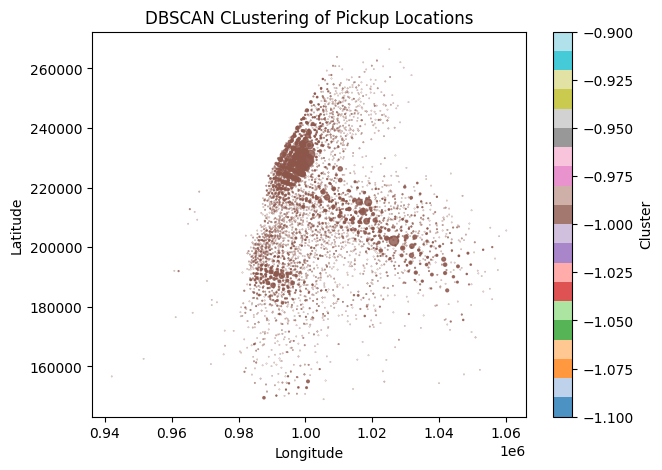

In [67]:
plt.figure(figsize=(7, 5))
k = plt.scatter(
    od_matrix['mid_lon'],
    od_matrix['mid_lat'], 
    c = od_matrix['cluster'], 
    cmap='tab20',
    s= od_matrix['count']/20,
    # edgecolor='none',
    alpha=0.8
)

plt.title('DBSCAN CLustering of Pickup Locations')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar(k, label='Cluster')
plt.show()

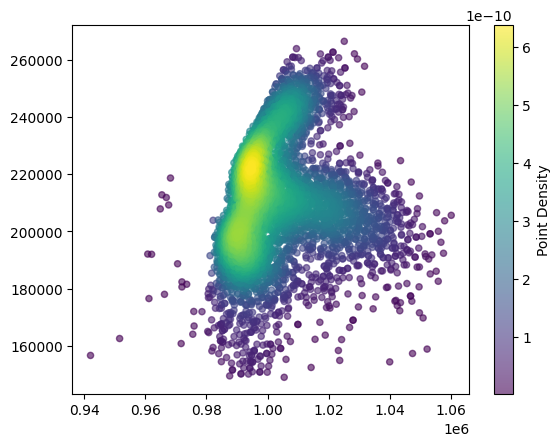

In [65]:
from scipy.stats import gaussian_kde

# 计算点密度
xy = np.vstack([od_matrix['mid_lon'], od_matrix['mid_lat']])
z = gaussian_kde(xy)(xy)

# 按密度排序（先画低密度点）
idx = z.argsort()
x, y, z = od_matrix['mid_lon'].iloc[idx], od_matrix['mid_lat'].iloc[idx], z[idx]

plt.scatter(x, y, c=z, s=20, cmap='viridis', alpha=0.6)
plt.colorbar(label='Point Density')